In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from itracker import *
import sys
import os 
import cv2
import torchvision.transforms as transforms

got ground truth with size: torch.Size([105, 2])
got images with size: torch.Size([105, 3, 384, 384])


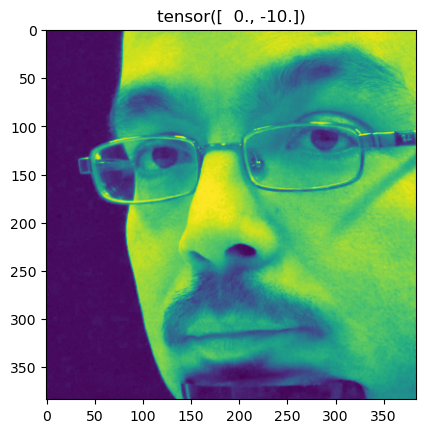

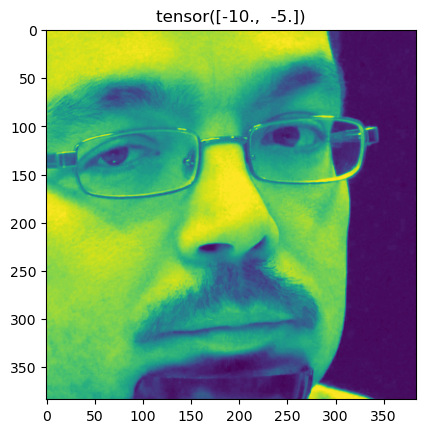

got ground truth with size: torch.Size([105, 2])
got images with size: torch.Size([105, 3, 384, 384])


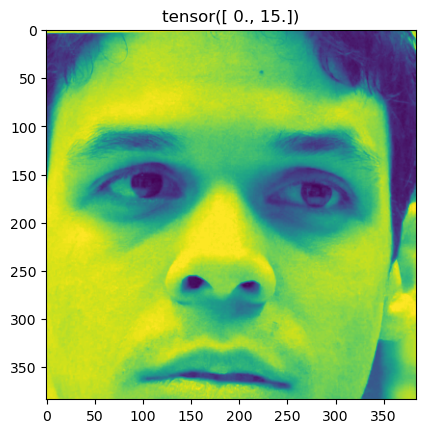

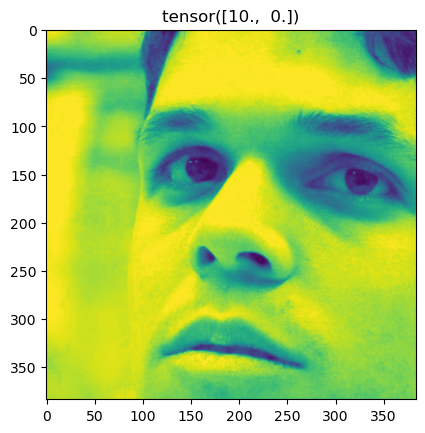

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch

i = [0,1]
path_gts = f"/Users/nattapolchanpaisit/Desktop/MLDA/datasets_face_384x384/data_gt_{i[0]}.csv"
path_images = f"/Users/nattapolchanpaisit/Desktop/MLDA/datasets_face_384x384/data_image_{i[0]}.csv"

def data_loader_from_csv(path = (path_gts, path_images)):
  my_data = np.genfromtxt(path[0], delimiter=',')
  gts = np.array(my_data).reshape((-1, 2))
  gts = torch.from_numpy(gts).to(torch.float)
  print(f"got ground truth with size: {gts.shape}")
  my_data = np.genfromtxt(path[1], delimiter=',')
  images = np.array(my_data).reshape((-1, 3, 384, 384))
  images = torch.from_numpy(images).to(torch.float)
  images = images / torch.max(torch.abs(images))
  print(f"got images with size: {images.shape}")
  for i in range(2):
    plt.imshow(images[i, 0, :, :])
    plt.title(gts[i])
    plt.show()
  return images, gts

images, gts = data_loader_from_csv((path_gts, path_images))
for each in range(1, len(i)):
  path_gts = f"/Users/nattapolchanpaisit/Desktop/MLDA/datasets_face_384x384/data_gt_{each}.csv"
  path_images = f"/Users/nattapolchanpaisit/Desktop/MLDA/datasets_face_384x384/data_image_{each}.csv"
  img, gr = data_loader_from_csv((path_gts, path_images))
  images, gts = torch.cat((img, images), dim=0), torch.cat((gr, gts), dim=0)

Download xml to detect left and right eye

In [21]:
path_to_xml = "/Users/nattapolchanpaisit/Desktop/MLDA/"
detect_right = cv2.CascadeClassifier('/Users/nattapolchanpaisit/GazeBST/KnowledgeDistillation/haarcascade_righteye_2splits.xml')
detect_left = cv2.CascadeClassifier('/Users/nattapolchanpaisit/GazeBST/KnowledgeDistillation/haarcascade_lefteye_2splits.xml')
images_copy = np.array(images * 128 + 128, dtype='uint8')

images_left = []
images_right = []

for i in range(len(images_copy)):
    eyes_left = detect_left.detectMultiScale(images_copy[i, 0, :, :],scaleFactor = 1.2, minNeighbors = 6)
    eyes_right = detect_right.detectMultiScale(images_copy[i, 0, :, :],scaleFactor = 1.2, minNeighbors = 6)
    # fig, (a1, a2, a3) = plt.subplots(1,3)
    if len(eyes_left) >= 1:
        for (ex,ey,ew,eh) in eyes_left[:1]:
            # a1.imshow(images[i, 0, ey:ey+eh, ex:ex+ew])
            img = transforms.Resize(224)(images[i, :, ey:ey+eh, ex:ex+ew])
            images_left.append(img)
    else:
        images_left.append(images[i])
    if len(eyes_left) >= 1:
        for (ex,ey,ew,eh) in eyes_right[:1]:
            # a2.imshow(images[i, 0, ey:ey+eh, ex:ex+ew])
            img = transforms.Resize(224)(images[i, :, ey:ey+eh, ex:ex+ew])
            images_right.append(img)
    else:
        images_right.append(images[i])
    # a3.imshow(images[i,0,:,:])
    # plt.show()

images_left = torch.stack(images_left)
images_right = torch.stack(images_right)

Train Model

In [50]:
if __name__ == '__main__':
    # m = ITrackerModel()
    images = transforms.Resize(224)(images)
    batch_size = 64
    num = sum(p.numel() for p in m.parameters())
    print(f"Itracker :: number of ALL param : {num}")
    model_parameters = filter(lambda p: p.requires_grad, m.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f"Itracker :: number of TRAINABLE param : {params}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(m.parameters(), lr=1e-5, weight_decay=1e-5)
    for epoch in range(50):
      if epoch % 15 == 0:
        for g in optimizer.param_groups:
          g['lr'] /= 1.2
      for i in range(len(images)//batch_size):
        feature = {
                    "face": images[i*batch_size : i*batch_size + batch_size],
                    "left": images_left[i*batch_size : i*batch_size + batch_size],
                    "right": images_right[i*batch_size : i*batch_size + batch_size],
                    "grid": torch.zeros(batch_size, 1, 25, 25)
                  }
        a = m(feature)
        loss = criterion(a, gts[batch_size*i : batch_size*i + batch_size])
        loss.backward()
        optimizer.step()
      print(f'{epoch+1}, loss: {loss}')

Itracker :: number of ALL param : 6286274
Itracker :: number of TRAINABLE param : 6286274
1, loss: 82.54866790771484
2, loss: 82.16556549072266
3, loss: 81.77142333984375
4, loss: 81.36763000488281
5, loss: 80.95567321777344
6, loss: 80.53033447265625
7, loss: 80.10479736328125
8, loss: 79.66459655761719
9, loss: 79.20217895507812
10, loss: 78.7267074584961
11, loss: 78.21099090576172
12, loss: 77.62416076660156
13, loss: 76.9480209350586
14, loss: 76.15522003173828
15, loss: 75.22506713867188
16, loss: 74.27999114990234
17, loss: 73.29852294921875
18, loss: 72.25841522216797
19, loss: 71.2086410522461
20, loss: 70.18622589111328
21, loss: 69.2064208984375
22, loss: 68.26347351074219
23, loss: 67.30887603759766
24, loss: 66.2870864868164
25, loss: 65.18290710449219
26, loss: 64.04328918457031
27, loss: 63.00242614746094
28, loss: 62.23084259033203
29, loss: 61.901676177978516
30, loss: 62.04740905761719
31, loss: 62.35942840576172
32, loss: 62.317481994628906
33, loss: 61.3946189880371

In [51]:
feature_test = {
            "face": images[:],
            "left": images_left[:],
            "right": images_right[:],
            "grid": torch.zeros(images.size(0), 1, 25, 25)
            }
gt_out = m(feature_test)
dif = (gt_out - gts[:])
def find_abs_angle_difference(a, b):
    cos_theta = torch.cos(a/180 * math.pi) * torch.cos(b/180 * math.pi) 
    theta = torch.acos(cos_theta)
    return torch.abs(theta * 180 / math.pi)
print(torch.sum(find_abs_angle_difference(gt_out, gts))/210)
print(torch.sum(find_abs_angle_difference(gt_out[-18:], gts[-18:]))/18)

tensor(21.9750, grad_fn=<DivBackward0>)
tensor(21.3968, grad_fn=<DivBackward0>)
